In [ ]:
from langchain_ollama import OllamaEmbeddings, OllamaLLM, ChatOllama
model = ChatOllama(model="llama3.2", temperature=0)

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:

def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [ ]:
graph_builder.add_edge(START, "chatbot")

In [ ]:
graph_builder.add_edge("chatbot", END)

In [ ]:
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)




In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

tool = DuckDuckGoSearchRun()

tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOllama(model="llama3.2", temperature=0)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [ ]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [ ]:
route_tools({"messages": [{"content": "What's a 'node' in LangGraph?"}]})

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

In [1]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
from typing import Annotated
from langchain_ollama import OllamaEmbeddings, OllamaLLM, ChatOllama

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = DuckDuckGoSearchRun(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.2", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [3]:
graph = graph_builder.compile(checkpointer=memory)

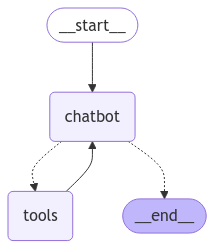

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
config = {"configurable": {"thread_id": "1"}}

In [6]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (a17c0bd9-48da-4e31-a154-f380dc53eccb)
 Call ID: a17c0bd9-48da-4e31-a154-f380dc53eccb
  Args:
    query: What is the meaning of a friendly hello?
================================= Tool Message =================================
Name: duckduckgo_search

This is a friendly greeting often associated with Australian culture. It's a way of saying "hello" or "good day" to someone in a cheerful and informal manner. For example, you might greet a friend by saying, "Good day mate! How's it going?" Here are some different ways to say "hello" to your good friends and younger relatives. 14. Yo! This funny greeting came from hip-hop culture in 1990s America. It is still commonly used in the US today. ... If you travel to the UK, you will notice that many people use the word "lovely

In [7]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (ad88d3a7-a6d2-48ce-9975-4d889f7e060e)
 Call ID: ad88d3a7-a6d2-48ce-9975-4d889f7e060e
  Args:
    query: What is the meaning of a friendly hello?
================================= Tool Message =================================
Name: duckduckgo_search

Learn the meaning of "Hi there" and when to use this casual, friendly greeting. Learn its origins, meaning, appropriate contexts, and alternatives for every communications. ... "Hi there" is a casual way to say hello. It's like giving your words a friendly hug. The "there" doesn't point to a place it's just there to make things warmer. This is a friendly greeting often associated with Australian culture. It's a way of saying "hello" or "good day" to someone in a cheerful and informal manner. For example, you might greet a friend 

In [8]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (5f4180a2-c200-4065-aa6d-17b24ce7092d)
 Call ID: 5f4180a2-c200-4065-aa6d-17b24ce7092d
  Args:
    query: What is the current name of the assistant?
================================= Tool Message =================================
Name: duckduckgo_search

Error: RatelimitException('https://links.duckduckgo.com/d.js?q=What+is+the+current+name+of+the+assistant%3F&kl=wt-wt&l=wt-wt&p=&s=0&df=y&vqd=4-316587822729699490587315521878695609962&bing_market=wt-WT&ex=-1 202 Ratelimit')
 Please fix your mistakes.
================================== Ai Message ==================================

Unfortunately, I don't have any information about a previous conversation or user name. Each time you interact with me, it's a new conversation. If you'd like to continue the conversation, I'm here to 

In [9]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='1d7be248-796a-4e49-a9f7-f0c4070cc68b'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-12-07T17:12:25.5480326Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17640323600, 'load_duration': 75545100, 'prompt_eval_count': 188, 'prompt_eval_duration': 12276000000, 'eval_count': 27, 'eval_duration': 5285000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': [{'function': {'name': 'duckduckgo_search', 'arguments': {'query': 'What is the meaning of a friendly hello?'}}}]}}, id='run-f1c86e9f-104e-47a7-8756-2c060a56a172-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'What is the meaning of a friendly hello?'}, 'id': 'a17c0bd9-48da-4e31-a154-f380dc53eccb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 188, 'output_tokens': 27, 'total_tokens':

In [3]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools import DuckDuckGoSearchRun
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = DuckDuckGoSearchRun()
tools = [tool]
llm = ChatOllama(model="llama3.2", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [4]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [5]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (b164e045-9302-4a17-b70b-d9733ee6b810)
 Call ID: b164e045-9302-4a17-b70b-d9733ee6b810
  Args:
    query: LangGraph


In [6]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [7]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'LangGraph'},
  'id': 'b164e045-9302-4a17-b70b-d9733ee6b810',
  'type': 'tool_call'}]

In [8]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (b164e045-9302-4a17-b70b-d9733ee6b810)
 Call ID: b164e045-9302-4a17-b70b-d9733ee6b810
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: duckduckgo_search

LangGraph, a powerful extension of the LangChain library, is designed to help developers build these advanced AI agents by enabling stateful, multi-actor applications with cyclic computation ... LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management. LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its ... Lang